In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

c:\users\avishek kumar\appdata\local\programs\python\python39\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\users\avishek kumar\appdata\local\programs\python\python39\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
!pip install transformers


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Preparation

In [3]:
# load the dataset
train_df = pd.read_csv('Corona_NLP_train.csv',  encoding = 'latin-1')
val_df = pd.read_csv('Corona_NLP_test.csv',  encoding = 'latin-1')
# test_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['text', 'emotion'], sep=';')

In [4]:
train_df.shape

(41157, 6)

In [5]:
train_df.drop(['UserName','ScreenName','Location','TweetAt'],axis=1,inplace=True)
train_df=train_df.rename(columns={"OriginalTweet":'text'})
train_df=train_df.rename(columns={"Sentiment":'emotion'})

In [6]:
train_df.head()

,text,emotion
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
val_df.drop(['UserName','ScreenName','Location','TweetAt'],axis=1,inplace=True)
val_df=val_df.rename(columns={"OriginalTweet":'text'})
val_df=val_df.rename(columns={"Sentiment":'emotion'})

In [8]:
val_df

,text,emotion
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


In [9]:
train_df=train_df[:10000]

## Quick EDA

## Unique emotions

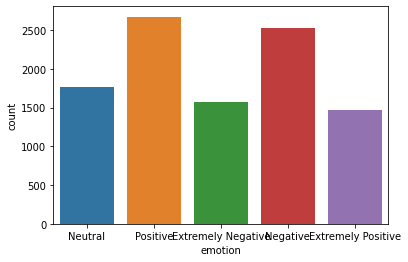

In [10]:
sns.countplot(data=train_df, x="emotion");

In [11]:
# encode the emotion column
le = LabelEncoder()
train_df['emotion'] = le.fit_transform(train_df['emotion'])
val_df['emotion']=le.fit_transform(val_df['emotion'])

In [12]:
!pip install spacy


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.7.0
    Uninstalling en-core-web-sm-3.7.0:
      Successfully uninstalled en-core-web-sm-3.7.0
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


**Imbalance can be seen in the labels**

In [14]:
!python -m spacy download en

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
pip install typing-extensions --upgrade

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1 requires torch==1.13.1, but you have torch 2.2.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import spacy

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
# convert it into one sentence without stop words and punctuations(.,-) and also with the base words.

In [19]:
train_df['processed_text'] = train_df["text"].apply(preprocess)

In [20]:
train_df['processed_text']

0       @MeNyrbie @Phil_Gahan @chrisitv https://t.co/i...
1       advice talk neighbour family exchange phone nu...
2       Coronavirus Australia woolworth elderly disabl...
3       food stock \r\r\n\r\r\n panic food need \r\r\n...
4       ready supermarket covid19 outbreak \r\r\n\r\r\...
                              ...                        
9995    pop food oldham \r\r\n Polite patient calm \r\...
9996    find paper towel week supermarket s treat reve...
9997    Coronavirus chaos IÂm grateful faith Jesus gr...
9998    Therapist Lisa Olivera give gratitude card gro...
9999    old people condition isolate say stay away peo...
Name: processed_text, Length: 10000, dtype: object

### Statistics about length of text

In [21]:
train_df['text_length'] = train_df['text'].apply(len)

In [22]:
summary = train_df['text_length'].describe()
summary

count    10000.000000
mean       208.253400
std         67.414038
min         11.000000
25%        156.000000
50%        220.000000
75%        264.000000
max        350.000000
Name: text_length, dtype: float64

**maximum length** of the text in the dataset is 300 but 75% of the values are behind 129 and median is around 86 thus there's a skewness present in the dataset

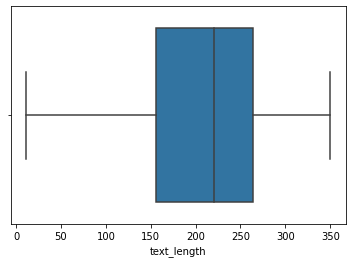

In [23]:
sns.boxplot(data=train_df, x='text_length');

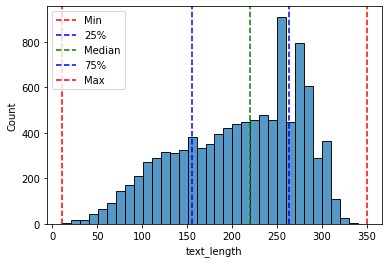

In [24]:
sns.histplot(data=train_df, x='text_length')
plt.axvline(summary['min'], color='r', linestyle='--', label='Min')
plt.axvline(summary['25%'], color='b', linestyle='--', label='25%')
plt.axvline(summary['50%'], color='g', linestyle='--', label='Median')
plt.axvline(summary['75%'], color='b', linestyle='--', label='75%')
plt.axvline(summary['max'], color='r', linestyle='--', label='Max')
plt.legend();

Since 75% of the values fall below length 129, using max_length 300 for our NLP algorithms would not be the best decision because it will result in sparser data because we will need to add a lot of padding to texts.

## Column Encoding

In [25]:

# val_df['emotion'] = val_df['emotion'].map({
#     'joy' : 0, 
#     'sadness': 1, 
#     'anger': 2, 
#     'fear': 3,
#     'love': 4,
#     'surprise':5
# })

In [26]:
val_df['emotion']

0       0
1       4
2       1
3       2
4       3
       ..
3793    4
3794    2
3795    3
3796    0
3797    1
Name: emotion, Length: 3798, dtype: int32

## Emotion Dataset

In [27]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = str(self.df.loc[index, 'text'])
        emotion = self.df.loc[index, 'emotion']
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion, dtype=torch.long)
        }

In [28]:
!pip install ipywidgets


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Tokenizer

In [29]:
pip install jupyter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# jupyter nbextension enable --py widgetsnbextension

SyntaxError: invalid syntax (2269694994.py, line 1)

In [31]:
# create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [32]:
# set the batch size
batch_size = 32

# set the maximum sequence length
max_len = 150

# create data loaders for the training and validation sets
train_dataset = EmotionDataset(train_df, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EmotionDataset(val_df, tokenizer, max_len)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model

In [33]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)
        
        return logits

In [34]:
bert_model_name = "bert-base-uncased"
num_classes = train_df["emotion"].nunique()
model = BertSentimentClassifier(bert_model_name, num_classes)

In [35]:
criterion = nn.CrossEntropyLoss()

# Training

In [36]:
def train(model, data_loader, optimizer, criterion, device):
    # set the model to train mode
    model.train()
    
    # initialize the loss and accuracy 
    total_loss, total_accuracy = 0, 0
    
    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # zero the gradient
        optimizer.zero_grad()
    
        # get the model's predictions
        outputs = model(input_ids, attention_mask)

        # get the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # accuracy calculation
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_accuracy += flat_accuracy(logits, label_ids)

        # perform backpropagation and optimization
        loss.backward()
        optimizer.step()

    # calculate the average loss
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_accuracy / len(data_loader)


    return avg_loss, avg_acc

In [37]:
def evaluate(model, data_loader, criterion, device):
    # set the model to eval mode
    model.eval()
    
    # initialize the loss and accuracy variables
    total_loss = 0
    total_accuracy = 0
    
    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # disable gradient computation
        with torch.no_grad():
            # get the model's predictions
            outputs = model(input_ids, attention_mask)
            
            # get the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # calculate the number of correct predictions
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            total_accuracy += flat_accuracy(logits, label_ids)
    
    # calculate the average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = total_accuracy / len(data_loader)
    
    return avg_loss, accuracy

In [38]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the learning rate
lr = 2e-5

# set the number of epochs
num_epochs = 2

# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# move the model to the device
model.to(device)

# lists to store metrics
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

# iterate over the epochs
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} ')
    # train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    
    # evaluate the model on the validation set
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # print the loss and accuracy
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
    # Save the loss and accuracy values
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save the model weights
    torch.save(model.state_dict(), f'weights_epoch{epoch + 1}.pt')

Epoch 1 


  1%|▌                                                                               | 2/313 [02:55<7:50:48, 90.83s/it]

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the training loss curve
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')
    
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].legend()
    
    # Plot the training accuracy curve
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(val_accuracies, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    
    plt.show()


# Test

In [ ]:
input_text = test_df.sample(n=1).text.values[0]
input_text

In [ ]:
encoded_input = tokenizer.encode_plus(
    input_text, 
    add_special_tokens=True,
    truncation=True,
    max_length= max_len,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
).to(device)

In [ ]:
emotion_id = torch.argmax(model(**encoded_input), dim=1).item()

In [ ]:
le.inverse_transform([emotion_id])

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)